## Modeling - RF Classifier

We are going to classify days as having outages or not based on the difference between the energy output of the two inverters. We'll use a rolling average in order to smooth things a bit.  

We will try modeling each inverter separately, and the modeling all the data together.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [2]:
df = pd.read_csv('../data/interim/filled_for_forecasting.csv', index_col = 0, parse_dates = True)

In [3]:
df.columns

Index(['Shark Meter, KWtotal Kilowatts', 'AE 500kW 1, AC Power Kilowatts',
       'AE 500kW 2, AC Power Kilowatts',
       '(Offline) Weather Station - POA (POA)* Watts/meter²',
       'RECx31 Weather Station, Module Temp Degrees Celsius',
       'RECx31 Weather Station, Ambient Temp Degrees Celsius',
       'AE 500kW 1, PV current Amps', 'AE 500kW 2, PV current Amps',
       'AE 500kW 1, PV voltage Volts', 'AE 500kW 2, PV voltage Volts'],
      dtype='object')

### Convert all 15-min data to hourly

In [4]:
# First calcluate difference between two inverters
df['Difference'] = df['AE 500kW 1, AC Power Kilowatts'] - df['AE 500kW 2, AC Power Kilowatts']

# Now get hourly energy in KWH
energy_hourly = df[['AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']].resample('H').mean()
energy_hourly.columns=['AE 500kW 1, KWH','AE 500kW 2, KWH']

energy_hourly['Max Module Temp'] = df['RECx31 Weather Station, Module Temp Degrees Celsius'].resample('H').max()
energy_hourly['Max Ambient Temp'] = df['RECx31 Weather Station, Ambient Temp Degrees Celsius'].resample('H').max()
energy_hourly['Max Difference'] = df['Difference'].resample('H').max()

# Now calculate the difference between the two inverters
energy_hourly['Difference'] = energy_hourly['AE 500kW 1, KWH'] - energy_hourly['AE 500kW 2, KWH']

### Resample to Daily Data and Fill Missing Data

We're going to resample to daily data, taking the max of the hourly temps (intuitively reasoning that max temp might be the most important feature of temperature), and summing the rest.  

In [5]:
energy_daily = \
    energy_hourly[['AE 500kW 1, KWH', 'AE 500kW 2, KWH', 'Difference']].resample('D').sum()
energy_daily[['Max Module Temp','Max Ambient Temp','Max Difference']] = \
    energy_hourly[['Max Module Temp','Max Ambient Temp','Max Difference']].resample('D').max()

In [6]:
energy_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1919 entries, 2015-10-01 to 2020-12-31
Freq: D
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AE 500kW 1, KWH   1919 non-null   float64
 1   AE 500kW 2, KWH   1919 non-null   float64
 2   Difference        1919 non-null   float64
 3   Max Module Temp   1919 non-null   float64
 4   Max Ambient Temp  1919 non-null   float64
 5   Max Difference    1875 non-null   float64
dtypes: float64(6)
memory usage: 104.9 KB


In [7]:
energy_daily.fillna(0, inplace=True)

### Classifying Outages

One of the things that is challenging here is that we don't have labeled data.  So we're going to have to decided which days had outages and which did not.  After looking at several different scenarios, I have decided to base this on a 3-day rolling average of the difference in daily energy production between the two inverters.  

Now we could use a clustering method to classify our days, but in reality since this is one-dimensional data and everything is centered around zero, we can just set a boundary around 0 and classify everything outside that boundary as an outage and everything inside that boundary as normal.  

In [8]:
# Take a rolling average
energy_daily_3Drolling = energy_daily['Difference'].rolling(window='3D').mean()

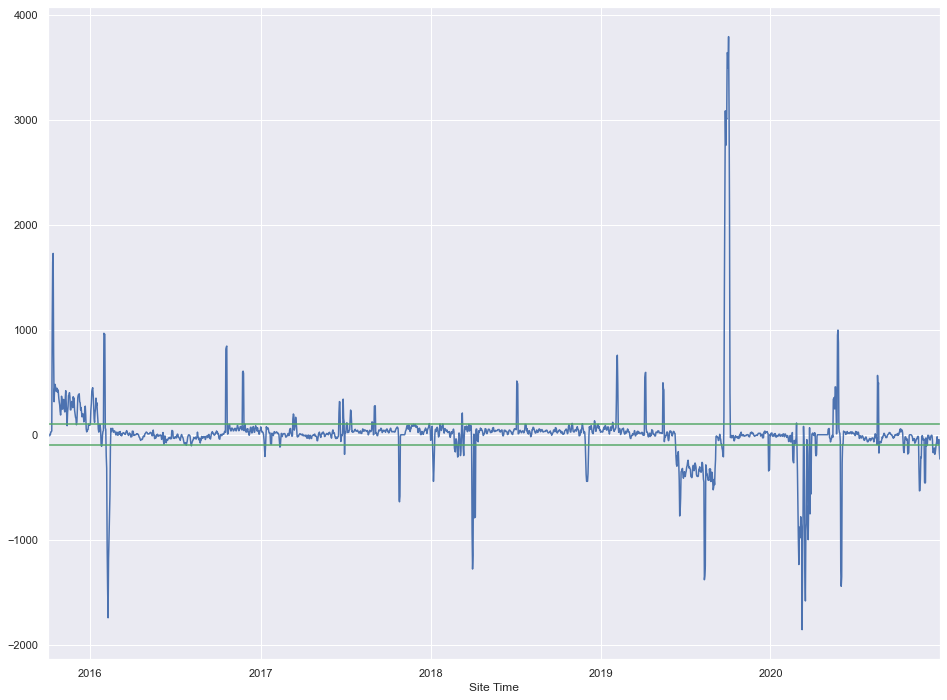

In [9]:
energy_daily_3Drolling.plot(figsize=(16,12));
plt.axhline(y=100, color='g', linestyle='-');
plt.axhline(y=-100, color='g', linestyle='-');

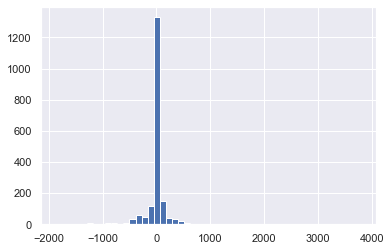

In [10]:
energy_daily_3Drolling.hist(bins=50);

We see here that the vast majority of the days, the 3D rolling average of the difference was very small, but then we have days when it is not.  So we want to use this knowledge to classify our days into "outages" for either Inverter 1 or Inverter 2. 

In [11]:
percs=np.zeros([40,2])
for i in range(40):
    perc = 1 - (abs(energy_daily_3Drolling)<10*(i+1)).sum() / energy_daily_3Drolling.shape[0]
    percs[i][0] = 10*(i+1)
    percs[i][1] = perc

In [12]:
percs = pd.DataFrame(percs, columns=['Difference Threshold','% of Outages'])

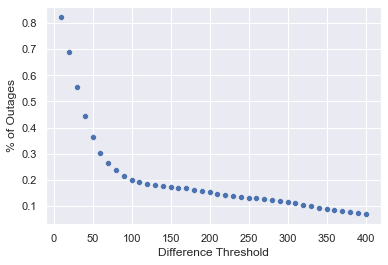

In [13]:
sns.scatterplot(data=percs, x='Difference Threshold',y = '% of Outages');

Intuitively you can see that it makes sense to choose a threshold at the 'elbow', or around 100.  This will give us a bit less than 20% of the days where we had problems.  

So, now we can take our data and split it into two dataframes, one for each inverter, and classify the days as problematic or not based on this threshold.  

In [18]:
# This is an attempt to set our target to just the first day of an outage with multiple days.  
# def zero_col(col):
#     '''converts a binary target into a multi-class target one zeros,ones, and twos'''
#     flag = col[0]
#     for i in range(1,len(col)):
#         if flag:
#             if col[i]==0:
#                 flag=False
#             else:
#                 col[i]=2
#         elif col[i]==1:
#             flag=True
#     return col

In [19]:
#Inverter1 = zero_col((energy_daily_3Drolling<-100).astype(int)).to_frame()
Inverter1 = (energy_daily_3Drolling<-100).to_frame()
Inverter1.columns=['Target']

#Inverter2 = zero_col((energy_daily_3Drolling> 100).astype(int)).to_frame()
Inverter2 = (energy_daily_3Drolling> 100).to_frame()
Inverter2.columns=['Target']

In [20]:
# Attempt to use KMeans to cluster outages - didn't work very well.
# from sklearn.cluster import KMeans

# kmeans = KMeans(n_clusters=3, random_state=0).fit(np.array(energy_daily_3Drolling['Difference']).reshape(-1,1))
# labels = kmeans.labels_

# cluster_1_pos = np.where(labels == 1)[0]
# cluster_2_pos = np.where(labels == 2)[0]

# x_1 = []; y_1 = [];
# for pos in cluster_1_pos:
#     x_1.append(np.array(energy_daily_3Drolling['Difference'])[pos])
#     y_1.append(energy_daily_3Drolling['Difference'].index[pos])
# x_2 = []; y_2 = [];
# for pos in cluster_2_pos:
#     x_2.append(np.array(energy_daily_3Drolling['Difference'])[pos])
#     y_2.append(energy_daily_3Drolling['Difference'].index[pos])

# plt.subplots(figsize=(12,8))
# plt.plot(energy_daily_3Drolling['Difference'].loc[energy_daily_3Drolling['Difference'].index])
# plt.plot(y_1,x_1,'r*', markersize=8) 
# plt.plot(y_2,x_2,'r*', markersize=8) 
# plt.legend(['Actual', 'Anomaly Detected'])


In [21]:
# This was an attempt to use DBSCAN to determine outages
# The following code is modified based on a blog post by ADITYA BHATTACHARYA.
# from sklearn.cluster import DBSCAN
# #clustering1 = DBSCAN(eps=0.09, min_samples=6).fit(np.array(energy_daily['Difference']).reshape(-1,1))
# clustering1 = DBSCAN(eps=5, min_samples=5).fit(np.array(energy_daily['Difference']).reshape(-1,1))

# labels = clustering1.labels_

# outlier_pos = np.where(labels == -1)[0]

# x = []; y = [];
# for pos in outlier_pos:
#     x.append(np.array(energy_daily['Difference'])[pos])
#     y.append(energy_daily['Difference'].index[pos])
    
# plt.subplots(figsize=(12,8))
# plt.plot(energy_daily['Difference'].loc[energy_daily['Difference'].index])
# plt.plot(y,x,'r*', markersize=8)  
# plt.legend(['Actual', 'Anomaly Detected'])
# plt.xlabel('Time Period')
# #plt.xticks([0, 20, 40, 60, 80, 99],[energ_daily.index[0],ts_dataframe.index[20], energy_daily.index[40], ts_dataframe.index[60], ts_dataframe.index[80], ts_dataframe.index[99]] ,rotation=45)
# plt.ylabel('Normalized Profit')

### Feature Engineering

We're going to add columns to our dataframe based on the historical data.  

In [22]:
# # Now let's have Inverter1 only see its issues and Inverter2 only see its
energy_daily['Diff_Inv1'] = energy_daily.apply(lambda x: 0 if x['Difference']>0 else x['Difference'], axis=1)
energy_daily['Diff_Inv2'] = energy_daily.apply(lambda x: 0 if x['Difference']<0 else x['Difference'], axis=1)

energy_daily['Max_Diff_Inv1'] = energy_daily.apply(lambda x: 0 if x['Max Difference']>0 else x['Max Difference'], axis=1)
energy_daily['Max_Diff_Inv2'] = energy_daily.apply(lambda x: 0 if x['Max Difference']<0 else x['Max Difference'], axis=1)

In [23]:
# Inverter 1
Inverter1['KWH_1'] = energy_daily['AE 500kW 1, KWH'].shift(1)
Inverter1['KWH_2'] = energy_daily['AE 500kW 1, KWH'].shift(2)
Inverter1['KWH_3'] = energy_daily['AE 500kW 1, KWH'].shift(3)
Inverter1['KWH_4'] = energy_daily['AE 500kW 1, KWH'].shift(4)
Inverter1['KWH_5'] = energy_daily['AE 500kW 1, KWH'].shift(5)
Inverter1['KWH_6'] = energy_daily['AE 500kW 1, KWH'].shift(6)
Inverter1['KWH_7'] = energy_daily['AE 500kW 1, KWH'].shift(7)

# Inverter 2
Inverter2['KWH_1'] = energy_daily['AE 500kW 2, KWH'].shift(1)
Inverter2['KWH_2'] = energy_daily['AE 500kW 2, KWH'].shift(2)
Inverter2['KWH_3'] = energy_daily['AE 500kW 2, KWH'].shift(3)
Inverter2['KWH_4'] = energy_daily['AE 500kW 2, KWH'].shift(4)
Inverter2['KWH_5'] = energy_daily['AE 500kW 2, KWH'].shift(5)
Inverter2['KWH_6'] = energy_daily['AE 500kW 2, KWH'].shift(6)
Inverter2['KWH_7'] = energy_daily['AE 500kW 2, KWH'].shift(7)

#Temperatures and irradiance are the same for both inverters
Inverter1['MMT_1'] = energy_daily['Max Module Temp'].shift(1)
Inverter2['MMT_1'] = energy_daily['Max Module Temp'].shift(1)
Inverter1['MMT_2'] = energy_daily['Max Module Temp'].shift(2)
Inverter2['MMT_2'] = energy_daily['Max Module Temp'].shift(2)
Inverter1['MMT_3'] = energy_daily['Max Module Temp'].shift(3)
Inverter2['MMT_3'] = energy_daily['Max Module Temp'].shift(3)
Inverter1['MMT_4'] = energy_daily['Max Module Temp'].shift(4)
Inverter2['MMT_4'] = energy_daily['Max Module Temp'].shift(4)
Inverter1['MMT_5'] = energy_daily['Max Module Temp'].shift(5)
Inverter2['MMT_5'] = energy_daily['Max Module Temp'].shift(5)
Inverter1['MMT_6'] = energy_daily['Max Module Temp'].shift(6)
Inverter2['MMT_6'] = energy_daily['Max Module Temp'].shift(6)
Inverter1['MMT_7'] = energy_daily['Max Module Temp'].shift(7)
Inverter2['MMT_7'] = energy_daily['Max Module Temp'].shift(7)

Inverter1['MAT_1'] = energy_daily['Max Ambient Temp'].shift(1)
Inverter2['MAT_1'] = energy_daily['Max Ambient Temp'].shift(1)
Inverter1['MAT_2'] = energy_daily['Max Ambient Temp'].shift(2)
Inverter2['MAT_2'] = energy_daily['Max Ambient Temp'].shift(2)
Inverter1['MAT_3'] = energy_daily['Max Ambient Temp'].shift(3)
Inverter2['MAT_3'] = energy_daily['Max Ambient Temp'].shift(3)
Inverter1['MAT_4'] = energy_daily['Max Ambient Temp'].shift(4)
Inverter2['MAT_4'] = energy_daily['Max Ambient Temp'].shift(4)
Inverter1['MAT_5'] = energy_daily['Max Ambient Temp'].shift(5)
Inverter2['MAT_5'] = energy_daily['Max Ambient Temp'].shift(5)
Inverter1['MAT_6'] = energy_daily['Max Ambient Temp'].shift(6)
Inverter2['MAT_6'] = energy_daily['Max Ambient Temp'].shift(6)
Inverter1['MAT_7'] = energy_daily['Max Ambient Temp'].shift(7)
Inverter2['MAT_7'] = energy_daily['Max Ambient Temp'].shift(7)

# #Difference between two inverters
# Inverter1['DIFF_1'] = energy_daily['Difference'].shift(1)
# Inverter2['DIFF_1'] = -energy_daily['Difference'].shift(1)
# Inverter1['DIFF_2'] = energy_daily['Difference'].shift(2)
# Inverter2['DIFF_2'] = -energy_daily['Difference'].shift(2)
# Inverter1['DIFF_3'] = energy_daily['Difference'].shift(3)
# Inverter2['DIFF_3'] = -energy_daily['Difference'].shift(3)
# Inverter1['DIFF_4'] = energy_daily['Difference'].shift(4)
# Inverter2['DIFF_4'] = -energy_daily['Difference'].shift(4)
# Inverter1['DIFF_5'] = energy_daily['Difference'].shift(5)
# Inverter2['DIFF_5'] = -energy_daily['Difference'].shift(5)
# Inverter1['DIFF_6'] = energy_daily['Difference'].shift(6)
# Inverter2['DIFF_6'] = -energy_daily['Difference'].shift(6)
# Inverter1['DIFF_7'] = energy_daily['Difference'].shift(7)
# Inverter2['DIFF_7'] = -energy_daily['Difference'].shift(7)

# # Max Difference between two inverters
# Inverter1['MAX_DIFF_1'] = energy_daily['Max Difference'].shift(1)
# Inverter2['MAX_DIFF_1'] = -energy_daily['Max Difference'].shift(1)
# Inverter1['MAX_DIFF_2'] = energy_daily['Max Difference'].shift(2)
# Inverter2['MAX_DIFF_2'] = -energy_daily['Max Difference'].shift(2)
# Inverter1['MAX_DIFF_3'] = energy_daily['Max Difference'].shift(3)
# Inverter2['MAX_DIFF_3'] = -energy_daily['Max Difference'].shift(3)
# Inverter1['MAX_DIFF_4'] = energy_daily['Max Difference'].shift(4)
# Inverter2['MAX_DIFF_4'] = -energy_daily['Max Difference'].shift(4)
# Inverter1['MAX_DIFF_5'] = energy_daily['Max Difference'].shift(5)
# Inverter2['MAX_DIFF_5'] = -energy_daily['Max Difference'].shift(5)
# Inverter1['MAX_DIFF_6'] = energy_daily['Max Difference'].shift(6)
# Inverter2['MAX_DIFF_6'] = -energy_daily['Max Difference'].shift(6)
# Inverter1['MAX_DIFF_7'] = energy_daily['Max Difference'].shift(7)
# Inverter2['MAX_DIFF_7'] = -energy_daily['Max Difference'].shift(7)

# # Difference between two inverters
Inverter1['DIFF_1'] = -energy_daily['Diff_Inv1'].shift(1)
Inverter2['DIFF_1'] = energy_daily['Diff_Inv2'].shift(1)
Inverter1['DIFF_2'] = -energy_daily['Diff_Inv1'].shift(2)
Inverter2['DIFF_2'] = energy_daily['Diff_Inv2'].shift(2)
Inverter1['DIFF_3'] = -energy_daily['Diff_Inv1'].shift(3)
Inverter2['DIFF_3'] = energy_daily['Diff_Inv2'].shift(3)
Inverter1['DIFF_4'] = -energy_daily['Diff_Inv1'].shift(4)
Inverter2['DIFF_4'] = energy_daily['Diff_Inv2'].shift(4)
Inverter1['DIFF_5'] = -energy_daily['Diff_Inv1'].shift(5)
Inverter2['DIFF_5'] = energy_daily['Diff_Inv2'].shift(5)
Inverter1['DIFF_6'] = -energy_daily['Diff_Inv1'].shift(6)
Inverter2['DIFF_6'] = energy_daily['Diff_Inv2'].shift(6)
Inverter1['DIFF_7'] = -energy_daily['Diff_Inv1'].shift(7)
Inverter2['DIFF_7'] = energy_daily['Diff_Inv2'].shift(7)

# Max Difference between two inverters
Inverter1['MAX_DIFF_1'] = -energy_daily['Max_Diff_Inv1'].shift(1)
Inverter2['MAX_DIFF_1'] = energy_daily['Max_Diff_Inv2'].shift(1)
Inverter1['MAX_DIFF_2'] = -energy_daily['Max_Diff_Inv1'].shift(2)
Inverter2['MAX_DIFF_2'] = energy_daily['Max_Diff_Inv2'].shift(2)
Inverter1['MAX_DIFF_3'] = -energy_daily['Max_Diff_Inv1'].shift(3)
Inverter2['MAX_DIFF_3'] = energy_daily['Max_Diff_Inv2'].shift(3)
Inverter1['MAX_DIFF_4'] = -energy_daily['Max_Diff_Inv1'].shift(4)
Inverter2['MAX_DIFF_4'] = energy_daily['Max_Diff_Inv2'].shift(4)
Inverter1['MAX_DIFF_5'] = -energy_daily['Max_Diff_Inv1'].shift(5)
Inverter2['MAX_DIFF_5'] = energy_daily['Max_Diff_Inv2'].shift(5)
Inverter1['MAX_DIFF_6'] = -energy_daily['Max_Diff_Inv1'].shift(6)
Inverter2['MAX_DIFF_6'] = energy_daily['Max_Diff_Inv2'].shift(6)
Inverter1['MAX_DIFF_7'] = -energy_daily['Max_Diff_Inv1'].shift(7)
Inverter2['MAX_DIFF_7'] = energy_daily['Max_Diff_Inv2'].shift(7)

# Add month of year
Inverter1['Month']=Inverter1.index.month
Inverter2['Month']=Inverter2.index.month

In [24]:
# Drop null values from doing the shifts
Inverter1.dropna(inplace=True)
Inverter2.dropna(inplace=True)

In [25]:
#Now reset the index and combine the two dataframes
Inverter1.reset_index(inplace=True)
Inverter2.reset_index(inplace=True)

Inverter1.drop(columns=['Site Time'], inplace=True)
Inverter2.drop(columns=['Site Time'], inplace=True)

In [26]:
def RF_pipeline(X_train, X_test, y_train, y_test, params):
    """This runs a pipeline for Random Forest Classification using
    the f1 score as the metric for optimizing the classifier"""
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('RF', RandomForestClassifier())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='recall')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))

### Train on Inverter1 Alone

In [27]:
X = Inverter1.copy()

y = X['Target']
X = X.drop(columns=['Target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [28]:
# Specify the hyperparameter space
parameters = { 'RF__max_depth': [3, 5, 7], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [100, 200]}   

RF_pipeline(X_train, X_test, y_train, y_test, parameters)

              precision    recall  f1-score   support

       False       0.97      1.00      0.99       342
        True       0.97      0.78      0.86        41

    accuracy                           0.97       383
   macro avg       0.97      0.89      0.93       383
weighted avg       0.97      0.97      0.97       383

Tuned Model Parameters: {'RF__criterion': 'gini', 'RF__max_depth': 7, 'RF__n_estimators': 100}

Confusion Matrix: 
 [[341   1]
 [  9  32]]


## Train on Inverter2 Alone

In [29]:
X = Inverter2.copy()

y = X['Target']
X = X.drop(columns=['Target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [30]:
# Specify the hyperparameter space
parameters = { 'RF__max_depth': [3, 5, 7], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [100, 200]}   

RF_pipeline(X_train, X_test, y_train, y_test, parameters)

              precision    recall  f1-score   support

       False       0.97      1.00      0.99       348
        True       1.00      0.71      0.83        35

    accuracy                           0.97       383
   macro avg       0.99      0.86      0.91       383
weighted avg       0.97      0.97      0.97       383

Tuned Model Parameters: {'RF__criterion': 'entropy', 'RF__max_depth': 7, 'RF__n_estimators': 100}

Confusion Matrix: 
 [[348   0]
 [ 10  25]]


### Train on Both Inverters

In [31]:
X = pd.concat([Inverter1, Inverter2])

y = X['Target']
X = X.drop(columns=['Target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Specify the hyperparameter space
parameters = { 'RF__max_depth': [3, 5, 7], \
              'RF__criterion': ['entropy', 'gini'], 'RF__n_estimators': [100, 200]}   

RF_pipeline(X_train, X_test, y_train, y_test, parameters)

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       697
        True       0.93      0.76      0.84        68

    accuracy                           0.97       765
   macro avg       0.95      0.88      0.91       765
weighted avg       0.97      0.97      0.97       765

Tuned Model Parameters: {'RF__criterion': 'gini', 'RF__max_depth': 7, 'RF__n_estimators': 200}

Confusion Matrix: 
 [[693   4]
 [ 16  52]]


### Train Final Model on All the Data

In [33]:
# Let's train our final model on all the training data and see how it does against the test data

RF = RandomForestClassifier(max_depth= 7, criterion = 'gini', n_estimators = 100)  
final_model = RF.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))

feature_importances = pd.DataFrame(final_model.feature_importances_, index = list(X_train.columns), \
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       697
        True       0.95      0.79      0.86        68

    accuracy                           0.98       765
   macro avg       0.96      0.89      0.93       765
weighted avg       0.98      0.98      0.98       765


Confusion Matrix: 
 [[694   3]
 [ 14  54]]
            importance
DIFF_2        0.281104
DIFF_1        0.250655
DIFF_3        0.083647
DIFF_4        0.065961
DIFF_5        0.049973
DIFF_6        0.049040
MAX_DIFF_1    0.025398
DIFF_7        0.020344
MAX_DIFF_2    0.018808
KWH_2         0.010573
KWH_1         0.009059
KWH_3         0.008501
MMT_1         0.008483
MAT_3         0.007463
MMT_2         0.007182
MMT_7         0.006695
KWH_5         0.006585
MMT_6         0.006497
MAT_4         0.006177
MAT_2         0.005865
MMT_3         0.005812
KWH_6         0.005755
MAT_5         0.005732
MMT_4         0.005383
KWH_7         0.005155
MAX_DIFF_3    0.005142
MMT_5   

### Try Support Vector Classifier

In [34]:
def SVC_pipeline(X_train, X_test, y_train, y_test, params):
    """This runs a pipeline for Support Vector Classification
    based on a subset of features.
    It uses the recallscore as the metric for optimizing the classifier"""
    
    # Subset X
    # Here we select the subset of features that we would like
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train).ravel()
    y_test = np.array(y_test).ravel()
        
    # Setup the pipeline
    steps = [('scaler',StandardScaler()), ('SVC', SVC())]
    pipeline = Pipeline(steps)

    # Instantiate the GridSearchCV object: cv
    cv = GridSearchCV(pipeline, params, cv=5, scoring='f1')

    # Fit to the training set
    cv.fit(X_train, y_train)

    # Predict our test data
    y_pred = cv.predict(X_test)

    # Compute and print metrics
    print(classification_report(y_test, y_pred))
    print("Tuned Model Parameters: {}".format(cv.best_params_))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))

In [35]:
X = pd.concat([Inverter1, Inverter2])

y = X['Target']
X = X.drop(columns=['Target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [36]:
# Specify the hyperparameter space
parameters = {'SVC__C': [.1, 1, 10], 'SVC__kernel': ['linear','rbf','poly'],'SVC__gamma': ['scale','auto']}   

SVC_pipeline(X_train, X_test, y_train, y_test, parameters)

              precision    recall  f1-score   support

       False       0.98      1.00      0.99       679
        True       0.96      0.81      0.88        86

    accuracy                           0.98       765
   macro avg       0.97      0.90      0.93       765
weighted avg       0.97      0.98      0.97       765

Tuned Model Parameters: {'SVC__C': 1, 'SVC__gamma': 'scale', 'SVC__kernel': 'linear'}

Confusion Matrix: 
 [[676   3]
 [ 16  70]]


In [37]:
# Let's train our final model on all the training data and see how it does against the test data
# This is really slow to train the final model.  Since the kernel is linear we can use LinearSVC.  

svc = LinearSVC(C=1)  
final_model = svc.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.39      0.56       679
        True       0.16      0.94      0.28        86

    accuracy                           0.45       765
   macro avg       0.57      0.66      0.42       765
weighted avg       0.89      0.45      0.52       765


Confusion Matrix: 
 [[263 416]
 [  5  81]]


/Users/ruthcsmith/opt/anaconda3/envs/TestEnv/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Arrgh...why did this model not do well?  I've read all the documentation and I think this should do well.  Llet's go back to regular SVC and just wait for it to complete.  Not sure why it's taking so long.  

In [38]:
svc = SVC(C=1, gamma = 'scale', kernel='linear')  
final_model = svc.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.99      0.98       679
        True       0.91      0.83      0.87        86

    accuracy                           0.97       765
   macro avg       0.94      0.91      0.92       765
weighted avg       0.97      0.97      0.97       765


Confusion Matrix: 
 [[672   7]
 [ 15  71]]


In [39]:
# This function modified based on Stack Overflow response by Jakub Macina
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.subplots(figsize=(12,12))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.title('Feature Importance for SVC Model')
    plt.show()

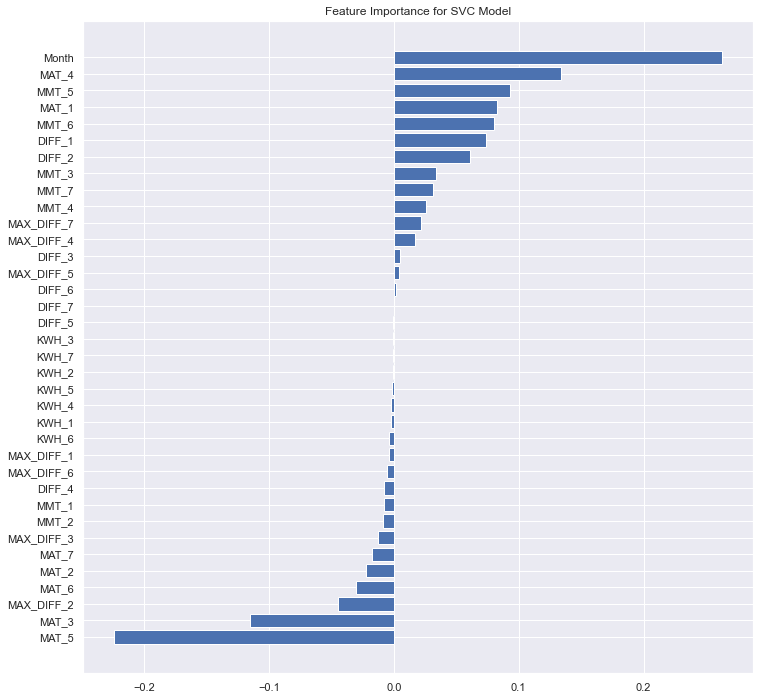

In [40]:
f_importances(svc.coef_[0], X.columns)

Interesting, it looks like SVC is finding more patterns other than just looking at the previous day's differences.  